In [1]:
import fnmatch, os, time
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
train = []
test = []

for root,dirs,files in os.walk('./seg/img'):
    if files:
        lst = os.listdir(root)
        png = fnmatch.filter(lst,'*.png')
        if png:
            for i in png:
                train.append((root+'/'+i, '/'.join(root.split('/')[:2])+'/mask/'+i))               

In [2]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
class MyDataset(Dataset):
    def __init__(self, image_path, transform = None, transform_label = None):
        self.image_list = image_path
        self.len = len(self.image_list)
        self.transform = transform
        self.transform_label = transform_label
    def __getitem__(self, index):
        fn, label = self.image_list[index]
        img = Image.open(fn)
        label = Image.open(label)
        if self.transform is not None:
            img = self.transform(img) 
            label = self.transform_label(label)
        return img, label
    def __len__(self):
        return self.len

Transform = transforms.Compose([
    #transforms.RandomRotation(degrees=15),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.CenterCrop(224),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
Lable_transfrom = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
    ])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv(x)
        return self.softmax(x)

In [5]:
 class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
 
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
 
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [6]:
class DiceLoss(nn.Module):
	def __init__(self):
		super(DiceLoss, self).__init__()
 
	def	forward(self, input, target):
		N = target.size(0)
		smooth = 1
 
		input_flat = input.view(N, -1)
		target_flat = target.view(N, -1)
 
		intersection = input_flat * target_flat
 
		loss = 2 * (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
		loss = 1 - loss.sum() / N
 
		return loss
 
class MulticlassDiceLoss(nn.Module):
	"""
	requires one hot encoded target. Applies DiceLoss on each class iteratively.
	requires input.shape[0:1] and target.shape[0:1] to be (N, C) where N is
	  batch size and C is number of classes
	"""
	def __init__(self):
		super(MulticlassDiceLoss, self).__init__()
 
	def forward(self, input, target):
 
		C = target.shape[1]
 
		# if weights is None:
		# 	weights = torch.ones(C) #uniform weights for all classes
 
		dice = DiceLoss()
		totalLoss = 0
 
		for i in range(C):
			diceLoss = dice(input[:,i], target[:,i])
			totalLoss += diceLoss
 
		return totalLoss

def Dice(input, target):
    N = target.size(0)
    smooth = 1

    input_flat = input.view(N, -1)
    target_flat = target.view(N, -1)

    intersection = input_flat * target_flat

    loss = 2 * (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
    loss = loss.sum() / N

    return loss

def MutilDice(input, target):
    C = target.shape[1]
 
    # if weights is None:
    # 	weights = torch.ones(C) #uniform weights for all classes

    totalLoss = 0

    for i in range(C):
        diceLoss = Dice(input[:,i], target[:,i])
        totalLoss += diceLoss

    return totalLoss

In [7]:
net = UNet(3,3)

In [8]:
from torch import nn,optim
loss_func = MulticlassDiceLoss()
#loss_func = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)

In [9]:
torch.cuda.current_device()

0

In [10]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(train, test_size = 0.2)

In [11]:
best_dice = 0
best_epoch = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_data = MyDataset(train_set, transform = Transform, transform_label = Lable_transfrom)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
test_data = MyDataset(test_set, transform = Transform, transform_label = Lable_transfrom)
test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=True)
net = net.to('cuda:0')
history = []

In [12]:
for epoch in range(500):
    epoch_start = time.time()
    net.train()
    print("Epoch: {}/{}".format(epoch+1, 500))
    train_loss = 0.0
    val_loss = 0.0
    for image, label in train_loader:
        optimizer.zero_grad()
        image = image.to(device)
        label = label.to(device)
        pred = net(image)
        loss = loss_func(pred,label)
        train_loss += loss.item() * image.shape[0]
        loss.backward()
        optimizer.step()
    avg_train_loss = 3 - train_loss/len(train_set)
    with torch.no_grad():
        net.eval()
        for image,label in test_loader:
            image = image.to(device)
            label = label.to(device)
            pred = net(image)
            loss = loss_func(pred,label)
            val_loss += loss.item() * image.shape[0]
    avg_val_loss = 3 - val_loss/len(test_set)
    if avg_val_loss > best_dice:
            best_dice = avg_val_loss
            best_epoch = epoch
            torch.save(net.state_dict(), 'best_model.pth')
    epoch_end = time.time()
    print('loss: {:.4f} ; train dice : {:.4f} ; val dice: {:.4f}; time: {:.4f}s'.format(3 - avg_train_loss, avg_train_loss, avg_val_loss, epoch_end-epoch_start))
    print("Best loss : {:.4f} at epoch {:03d}".format(best_dice, best_epoch))
    history.append(avg_train_loss)

Epoch: 1/500
loss: 2.6763 ; train dice : 0.3237 ; val dice: 0.0427; time: 11.3454s
Best loss : 0.0427 at epoch 000
Epoch: 2/500
loss: 2.3721 ; train dice : 0.6279 ; val dice: 0.0848; time: 10.3367s
Best loss : 0.0848 at epoch 001
Epoch: 3/500
loss: 2.3563 ; train dice : 0.6437 ; val dice: 0.5393; time: 10.4384s
Best loss : 0.5393 at epoch 002
Epoch: 4/500
loss: 2.2924 ; train dice : 0.7076 ; val dice: 0.6817; time: 10.4331s
Best loss : 0.6817 at epoch 003
Epoch: 5/500
loss: 2.2698 ; train dice : 0.7302 ; val dice: 0.6543; time: 10.3782s
Best loss : 0.6817 at epoch 003
Epoch: 6/500
loss: 2.2419 ; train dice : 0.7581 ; val dice: 0.5445; time: 10.4248s
Best loss : 0.6817 at epoch 003
Epoch: 7/500
loss: 2.2601 ; train dice : 0.7399 ; val dice: 0.6511; time: 10.4606s
Best loss : 0.6817 at epoch 003
Epoch: 8/500
loss: 2.2067 ; train dice : 0.7933 ; val dice: 0.7494; time: 10.4616s
Best loss : 0.7494 at epoch 007
Epoch: 9/500
loss: 2.1768 ; train dice : 0.8232 ; val dice: 0.7546; time: 10.476

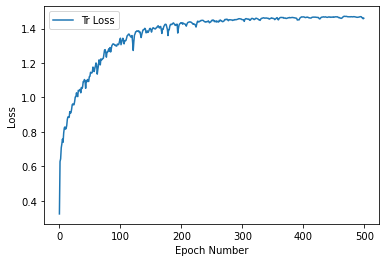

In [13]:
history = np.array(history)
plt.plot(history)
plt.legend(['Tr Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

In [14]:
import imageio
net.load_state_dict(torch.load('best_model.pth', map_location=device))
i = 0
for image, label in train_loader:
    print(label.shape[1])
    image = image.to(device=device, dtype=torch.float32)
    label = label.to(device=device, dtype=torch.float32)
    pred = net(image)
    loss = loss_func(pred,label)
    print(loss.item())
    pred = np.array(pred.data.cpu()[0])
    label = np.array(label.data.cpu()[0])
    pred[pred >= 0.5] = 255
    pred[pred < 0.5] = 0
    i+=1
    pred = pred[0]
    label = label[0]
    #pred = pred.transpose(1,2,0)
    #label = label.transpose(1,2,0)
    imageio.imwrite('./res/' + str(i) + '.png', pred)
    imageio.imwrite('./res/' + str(i) + '_label.png', label*255)

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


3
1.5778248310089111
3


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 10.76 GiB total capacity; 8.79 GiB already allocated; 249.19 MiB free; 9.57 GiB reserved in total by PyTorch)